# TCC: Análise de métricas para métodos de aprendizado de máquina

A base utilizada é a de [fraudes em cartão de crédito disponível no Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud), pois esta base não possui dados categóricos, apenas números com pontos flutuantes e não possui `NaN`s ou `nulls`.

O método de classificação escolhido foi a regressão logística, pois ela permite analisar os componentes que descrevem a função aprendida para realizar a classificação atravéz dos pesos encontrados para cada uma das variáveis de entrada.

O desenvolvimento foi realizado em python usando `pandas`, `scikit-learn`, `SMOTE` para o aprendizado, `matplotlib` para a geração de gráficos e `numpy` e `scipy` como dependência destas bibliotecas. O código foi desenvolvido usando `Jupyter Lab`. Este ambiente foi escolhido por ser uma [configuração comumente usada em empresas](https://youtu.be/clck97Bwy4M) An 

## Leitura da base de dados escolhida e verificação das variáveis

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("creditcard.csv")
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Verificação de `NaN`s e `nulls` na base

In [3]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Portanto, todas as variáveis possuem valores e nenhuma é `NaN` ou `null`, desta forma, não será necessário tratar valores não existentes no dataset.

## Estrutura de dados para armazenar as variáveis de treinamento

Será utilizado um dicionário para armazenar as informações de cada classificador, no formato:

    {"classificador": objeto gerado com o classificador,
      "x_treino": variáveis de entrada para treino, 
      "y_treino": variáveis de saída para treino,
      "x_teste": variáveis de entrada para teste,
      "y_teste": variáveis de saída para teste,
      "y_prev": resultado da previsão de y_teste com o classificador treinado com x_teste e y_teste,
      "y_prob": probabilidade de classificação da entrada como uma das classes
     }
     
Estes dados serão armazenados no dicionário `testes` com as informações de cada classificador, porém neste ponto ainda não será realizado o processo de aprendizado. Este passo será realizado no final, para que seja medido o tempo de execução do aprendizado com cada configuração da base de testes.

O dataset será dividido em 70% para treino e 30% para teste.

In [8]:
from sklearn.linear_model import LogisticRegression as Classificador
from sklearn.model_selection import train_test_split

fracao_teste = 0.3
testes = dict()

## Primeiro classificador: utilizando o dataset sem pré-processamento

In [9]:
X1 = data.drop('Class', axis=1).values
Y1 = data.Class.values
x_treino1, x_teste1, y_treino1, y_teste1 = train_test_split(X1, Y1, test_size=fracao_teste)

In [10]:
testes["Sem tratamento"] = {"classificador": Classificador(),
                            "x_treino": x_treino1,
                            "y_treino": y_treino1,
                            "x_teste": x_teste1,
                            "y_teste": y_teste1}

## Segundo classificador: usando apenas balanceamento

Primeiro é necessário verificar se a quantidade de dados classificados como `fraude` é diferente de `não fraude`.

In [11]:
temp = data[['Amount', 'Class']].groupby('Class').count()
temp['Proporção'] = (temp.Amount / data.Class.count()) * 100
temp

,Amount,Proporção
Class,,
0,284315,99.827251
1,492,0.172749


A patir da tabela acima, 99,82% da base é de `não fraude` e apenas 0.17% é de `fraude`. Portanto, é necessário realizar o balanceamento da amostra.

In [17]:
from imblearn.over_sampling import SMOTE
X_desb = data.drop('Class', axis=1).values
Y_desb = data.Class.values
X2, Y2 = SMOTE().fit_sample(X_desb, Y_desb)

In [18]:
print("Tamanho das amostras:\tX\t\tY")
print("Desbalanceado:\t\t{}\t{}".format(X_desb.shape, Y_desb.shape))
print("Balanceado:\t\t{}\t{}".format(X2.shape, Y2.shape))

print("\nAmostra\t\tFraude\tNão fraude")
print("Desbalanceado:\t{:>}\t{:>}".format(sum(Y_desb==1), sum(Y_desb==0)))
print("Balanceado:\t{:>}\t{:>}".format(sum(Y2==1), sum(Y2==0)))

Tamanho das amostras:	X		Y
Desbalanceado:		(284807, 30)	(284807,)
Balanceado:		(568630, 30)	(568630,)

Amostra		Fraude	Não fraude
Desbalanceado:	492	284315
Balanceado:	284315	284315


Portanto, utilizando `SMOTE` foi possível criar uma base balanceada.

In [19]:
x_treino2, x_teste2, y_treino2, y_teste2 = train_test_split(X2, Y2, test_size=fracao_teste)

testes["Com balanceamento"] = {"classificador": Classificador(),
                               "x_treino": x_treino2,
                               "y_treino": y_treino2,
                               "x_teste": x_teste2,
                               "y_teste": y_teste2}

## Terceiro classificador: usando apenas redução de dimensionalidade

É possível que algumas variáveis medidas não apresentem diferença entre as classes das amostras e, portanto, não fazem diferença para o classificador. Desta forma, é possível fazer o aprendizado sem utilizar estas variáveis.

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Primeiro, verificar a correlação entre as variáveis.

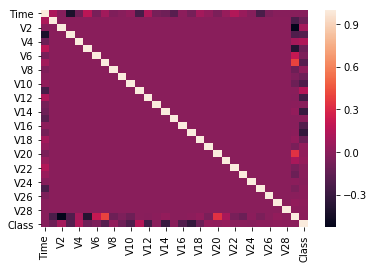

In [24]:
sns.heatmap(data.corr())

Como a maioria das variáveis não apresenta correlação com outras (cores mais escuras), nenhuma será removida por este motivo. Entretanto, será feita agora a análise das classe dentro da própria variável.

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


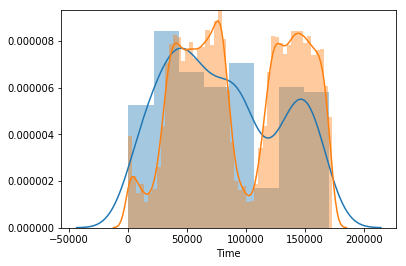

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


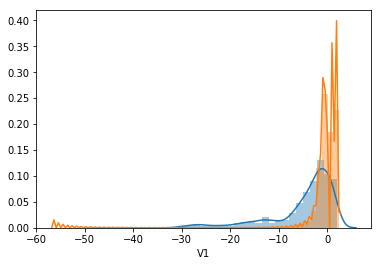

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


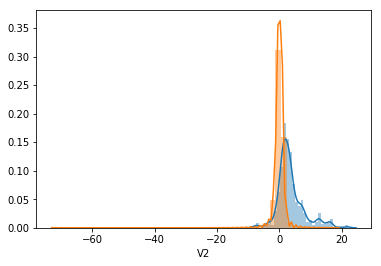

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


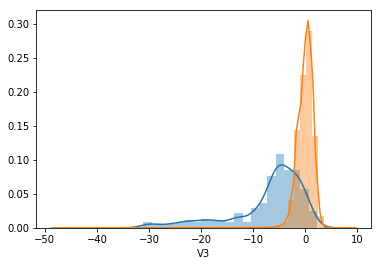

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


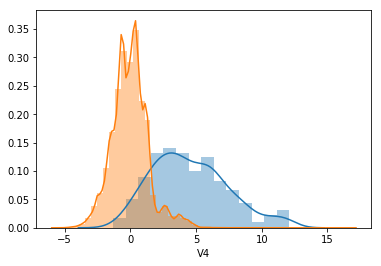

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


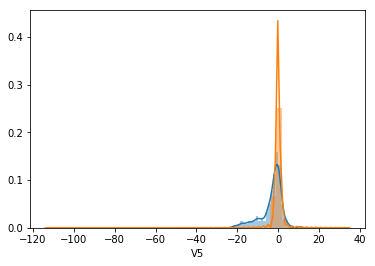

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


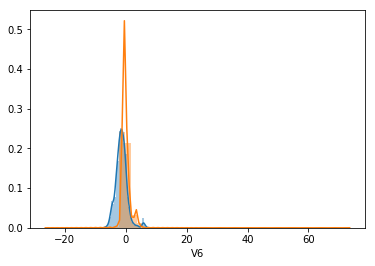

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


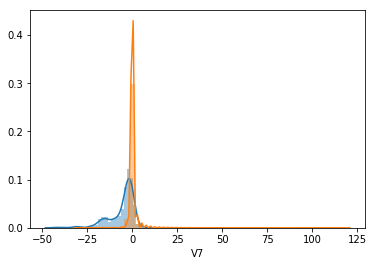

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


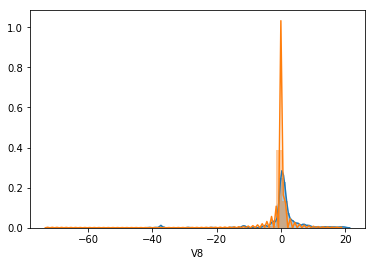

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


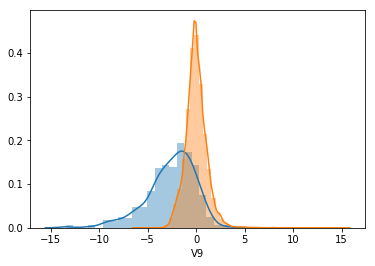

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


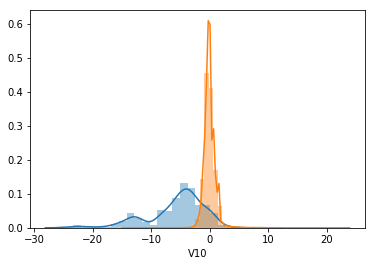

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


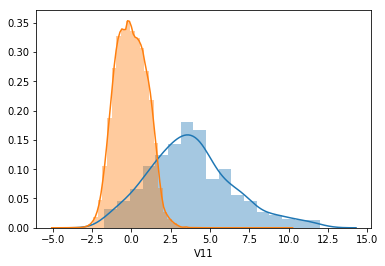

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


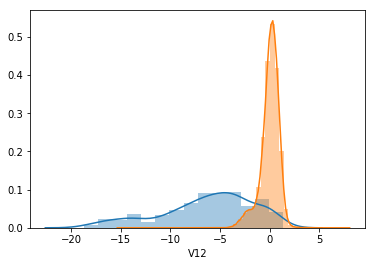

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


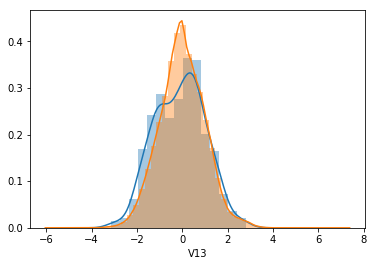

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


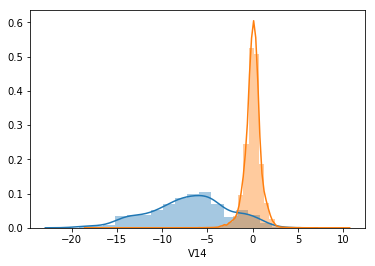

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


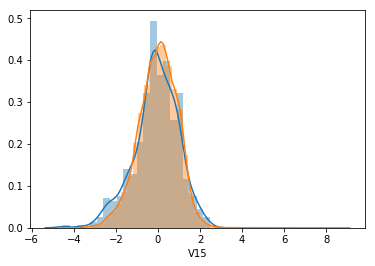

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


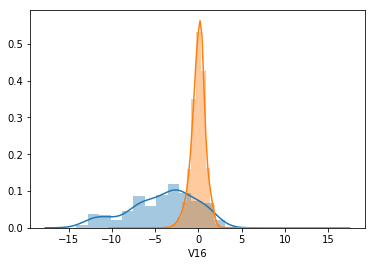

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


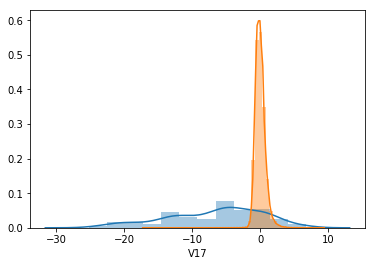

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


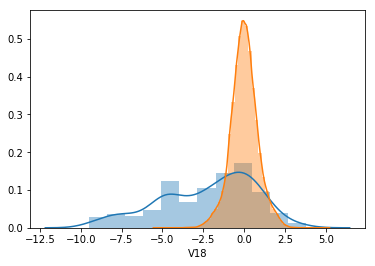

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


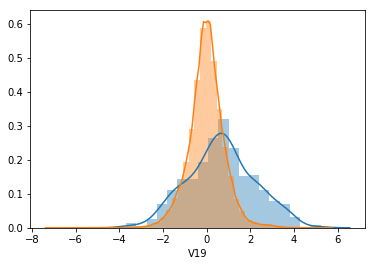

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


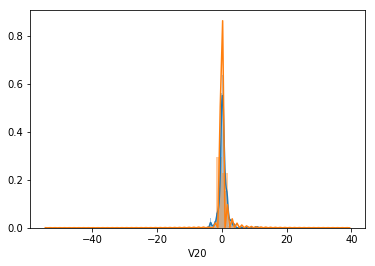

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


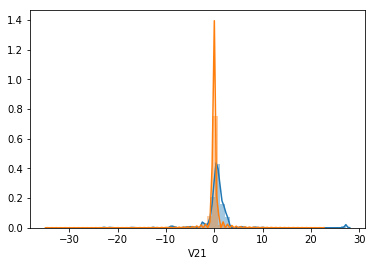

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


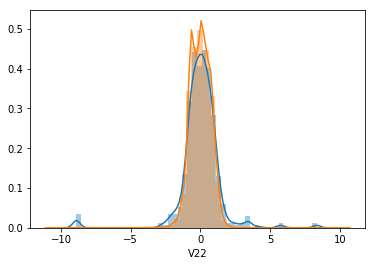

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


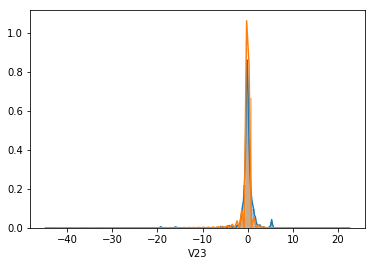

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


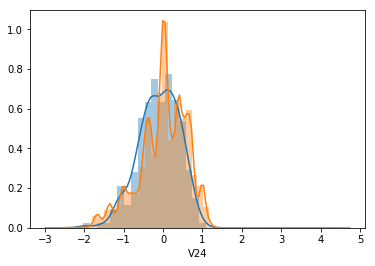

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


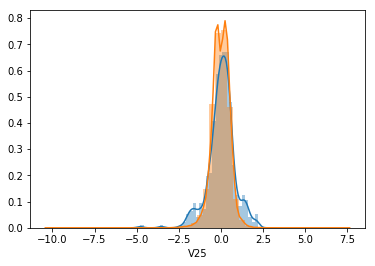

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


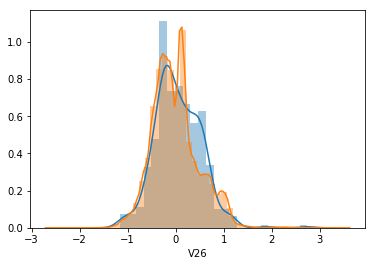

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


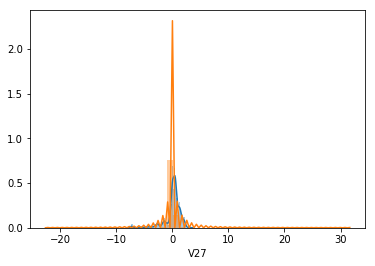

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


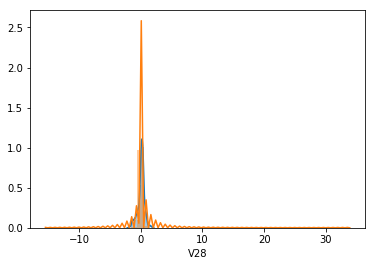

/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/francisco/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


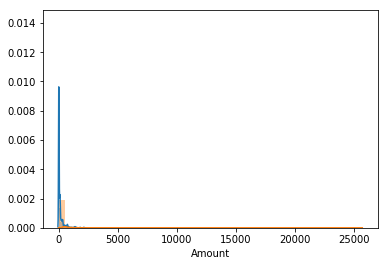

In [23]:
fraude = data.Class == 1
não_fraude = data.Class == 0

for var in data.columns[:-1]:
    sns.distplot(data[fraude][var])
    sns.distplot(data[não_fraude][var])
    plt.show()

As variáveis `Time`, `V8`, `V13`, `V15`, `V20`, `V22`, `V23`, `V24`, `V25`, `V26`, `V27`,`V28` podem ser removidas, pois as amostras para `fraude` e `não fraude` são iguais.

In [25]:
remover = ["Time", "V8", "V13", "V15", "V20", "V22", "V23", "V24", "V25", "V26", "V27", "V28"]
data3 = data.drop(remover, axis=1)

In [26]:
X3 = data3.drop('Class', axis=1).values
Y3 = data3.Class.values
x_treino3, x_teste3, y_treino3, y_teste3 = train_test_split(X3, Y3, test_size=fracao_teste)

In [27]:
testes["Com redução"] = {"classificador": Classificador(),
                         "x_treino": x_treino3,
                         "y_treino": y_treino3,
                         "x_teste": x_teste3,
                         "y_teste": y_teste3}

## Quarto classificador: usando balanceamento e redução de dimensionalidade

Como a base precisa de balanceamento (conforme mostrado no segundo classificador) e também permite a redução de dimensionalidade (terceiro classificador), o último teste junta os dois métodos.

Utilizando a amostra com redução feita no classificador anterior, neste passo será apenas realizado balanceamento conforme o segundo classificador.

In [28]:
X4, Y4 = SMOTE().fit_sample(X3, Y3)

In [29]:
print("Tamanho das amostras:\tX\t\tY")
print("Desbalanceado:\t\t{}\t{}".format(X_desb.shape, Y_desb.shape))
print("Balanceado:\t\t{}\t{}".format(X4.shape, Y4.shape))

print("\nAmostra\t\tFraude\tNão fraude")
print("Desbalanceado:\t{:>}\t{:>}".format(sum(Y_desb==1), sum(Y_desb==0)))
print("Balanceado:\t{:>}\t{:>}".format(sum(Y4==1), sum(Y4==0)))

Tamanho das amostras:	X		Y
Desbalanceado:		(284807, 30)	(284807,)
Balanceado:		(568630, 18)	(568630,)

Amostra		Fraude	Não fraude
Desbalanceado:	492	284315
Balanceado:	284315	284315


In [19]:
x_treino4, x_teste4, y_treino4, y_teste4 = train_test_split(X4, Y4, test_size=fracao_teste)

testes["Com redução e balanceamento"] = {"classificador": Classificador(),
                                         "x_treino": x_treino4,
                                         "y_treino": y_treino4,
                                         "x_teste": x_teste4,
                                         "y_teste": y_teste4}

## Classificação das bases

Uma vez que todos os classificadores e bases de treino e teste foram criados, nesta parte serão realizados os treinamentos do classificador. Na seção seguinte, serão realizadas algumas medidas de desempenho.

O classificador escolhido foi a regressão logistica que possui a forma 
$$classe(x) = \cfrac{1}{1+e^{- f(x)}}$$
em que  $$f(x) = w_1 X_1 + w_2 X_2 + \ldots + w_n X_n$$ 
onde, $X_i$ é o valor de entrada na variável e $w_i$ é o valor do peso da variável $i$. Para o classificador criado a partir do `scikit-learn`, os valores de $w_i$ estão armazenados no atributo `coef_` do objeto `classificador`.

In [20]:
from time import time

In [21]:
for t in testes:
    print("-"*80)
    print("Classificador:\t{}".format(t), end="\t")
    teste = testes[t]
    x_treino = teste["x_treino"]
    y_treino = teste["y_treino"]
    classificador = teste["classificador"]
    
    t_inicio = time()
    classificador.fit(x_treino, y_treino)
    t_fim = time()
    
    print("tempo de execução: {:.5f} segundos".format(t_fim - t_inicio))
    
    print("-"*80)
    
    teste["y_prev_treino"] = classificador.predict(x_treino)
    teste["y_prob_treino"] =  1 - classificador.predict_proba(x_treino).T[0]
    print(classificador.coef_)
    print("-"*80, end="\n\n")

    x_teste = teste["x_teste"]
    teste["y_prev_teste"] = classificador.predict(x_teste)
    teste["y_prob_teste"] = 1 - classificador.predict_proba(x_teste).T[0]


--------------------------------------------------------------------------------
Classificador:	Sem tratamento	tempo de execução: 3.11900 segundos
--------------------------------------------------------------------------------
[[-8.99777361e-05  1.60490557e-01 -3.44087446e-01 -7.77987941e-01
   1.39186897e-01 -1.80761285e-02 -8.42329047e-02  5.48250633e-02
  -1.29306152e-01 -3.84192666e-01 -2.00505041e-01 -1.34116886e-01
  -1.93461658e-02 -2.70851123e-01 -7.11685443e-01 -1.95898540e-01
  -2.46493599e-01 -4.44099517e-01 -9.70918926e-03  3.02487876e-02
   3.99235796e-02  1.48662604e-01  1.82778566e-01  1.50506736e-02
  -3.41852105e-02 -1.57855864e-01  1.80505399e-02 -4.67243021e-02
   3.03579043e-02 -6.83840186e-03]]
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Classificador:	Com balanceamento	tempo de execução: 10.76674 segundos
-----------------------------------------

## Análise dos classificadores

Com os classificadores treinados com as diferentes bases, nesta parte são calculadas algumas métricas comumente utilizadas em classificadores.

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

### Análise sobre os valores usados para treino

--------------------------------------------------------------------------------
Teste:	Sem tratamento
--------------------------------------------------------------------------------

             precision    recall  f1-score   support

 Não fraude       1.00      1.00      1.00    199024
     Fraude       0.73      0.61      0.66       340

avg / total       1.00      1.00      1.00    199364


Matriz de confusão:
[[198946     78]
 [   132    208]]

Área sob a curva ROC: 0.90717
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Teste:	Com balanceamento
--------------------------------------------------------------------------------

             precision    recall  f1-score   support

 Não fraude       0.94      0.99      0.96    199048
     Fraude       0.98      0.94      0.96    198993

avg / total       0.96      0.96      0.96    398041


Matriz de confusão:
[[19614

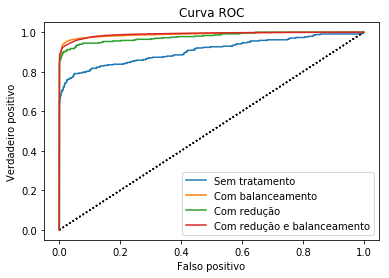

In [23]:
for t in testes:
    teste = testes[t]
    y_esp = teste["y_treino"]
    y_prev = teste["y_prev_treino"]
    y_prob = teste["y_prob_treino"]
    
    print("-"*80)
    print("Teste:\t{}".format(t))
    print("-"*80, end="\n\n")
    print(classification_report(y_esp, y_prev, target_names=["Não fraude", "Fraude"]), end="\n\n")
    
    print("Matriz de confusão:")
    print(confusion_matrix(y_esp, y_prev), end="\n\n")
    
    fp, tp, _ = roc_curve(y_esp, y_prob)
    plt.plot([0, 1], [0, 1], 'k:')
    plt.plot(fp, tp, label=t)
    plt.title("Curva ROC")
    plt.xlabel("Falso positivo")
    plt.ylabel("Verdadeiro positivo")
    plt.legend(loc="best")
    print("Área sob a curva ROC: {:.5f}".format(auc(fp, tp)))
    
    print("-"*80, end="\n\n")

### Análise para os valores de teste

--------------------------------------------------------------------------------
Teste:	Sem tratamento
--------------------------------------------------------------------------------

             precision    recall  f1-score   support

 Não fraude       1.00      1.00      1.00     85291
     Fraude       0.72      0.61      0.66       152

avg / total       1.00      1.00      1.00     85443


Matriz de confusão:
[[85254    37]
 [   59    93]]

Área sob a curva ROC: 0.91110
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Teste:	Com balanceamento
--------------------------------------------------------------------------------

             precision    recall  f1-score   support

 Não fraude       0.94      0.99      0.96     85267
     Fraude       0.98      0.94      0.96     85322

avg / total       0.96      0.96      0.96    170589


Matriz de confusão:
[[84011  12

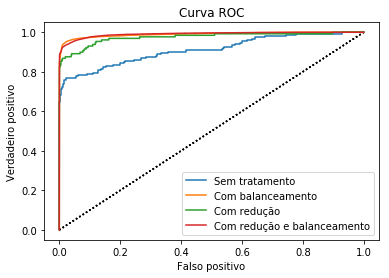

In [24]:
for t in testes:
    teste = testes[t]
    y_esp = teste["y_teste"]
    y_prev = teste["y_prev_teste"]
    y_prob = teste["y_prob_teste"]
    
    print("-"*80)
    print("Teste:\t{}".format(t))
    print("-"*80, end="\n\n")
    print(classification_report(y_esp, y_prev, target_names=["Não fraude", "Fraude"]), end="\n\n")
    
    print("Matriz de confusão:")
    print(confusion_matrix(y_esp, y_prev), end="\n\n")
    
    fp, tp, _ = roc_curve(y_esp, y_prob)
    plt.plot([0, 1], [0, 1], 'k:')
    plt.plot(fp, tp, label=t)
    plt.title("Curva ROC")
    plt.xlabel("Falso positivo")
    plt.ylabel("Verdadeiro positivo")
    plt.legend(loc="best")
    print("Área sob a curva ROC: {:.5f}".format(auc(fp, tp)))
    
    print("-"*80, end="\n\n")